In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import coupled_oscillator as co

# defining the parameters
endtime = 4 * np.pi
gravity = 1
mass = 1
length = 1
spring_constant = 10**2  # freqency of spring is 10 times the frequency of pendulum
osc_prop = co.OscillatorProperties(
    gravity=gravity, mass=mass, length=length, spring_constant=spring_constant, epsilon=0)
hamiltonian = co.Hamiltonian(osc_prop)  # This defines the system of equations

# defining the initial conditions
angle_deg = -45
angle_rad = np.deg2rad(angle_deg)
spring_displacement = 0.1
phase_ini = co.Phase(osc_prop, angle=angle_rad, displacement=spring_displacement)

# Let's solve the system for one period of the pendulum
solution = co.solve(
    hamiltonian=hamiltonian, 
    phase=phase_ini, 
    time_span=[0, endtime], 
    num_points=1000, 
    max_step=0.01)

# Compute the energy of the system
def compute_energies(ds_phase: xr.Dataset) -> xr.Dataset:
    time = ds_phase.time.item()
    phase = co.Phase.from_xr(osc_prop, ds_phase)
    # compute the energies of the system
    ekin = hamiltonian.kinetic_energy(phase, time=time)
    epot = hamiltonian.potential_energy(phase, time=time)
    etot = ekin + epot
    # return the energies
    ds_energy = xr.Dataset({
        'time': xr.DataArray(
            [time], dims=['time'], attrs={'units': 's'}),
        'ekin': xr.DataArray(
            [ekin], dims=['time'], attrs={'long_name': 'Kinetic Energy'}),
        'epot': xr.DataArray(
            [epot], dims=['time'], attrs={'long_name': 'Potential Energy'}),
        'etot': xr.DataArray(
            [etot], dims=['time'], attrs={'long_name': 'Total Energy'}),
    })
    return ds_energy

energy_evolution = solution.groupby('time').map(compute_energies)

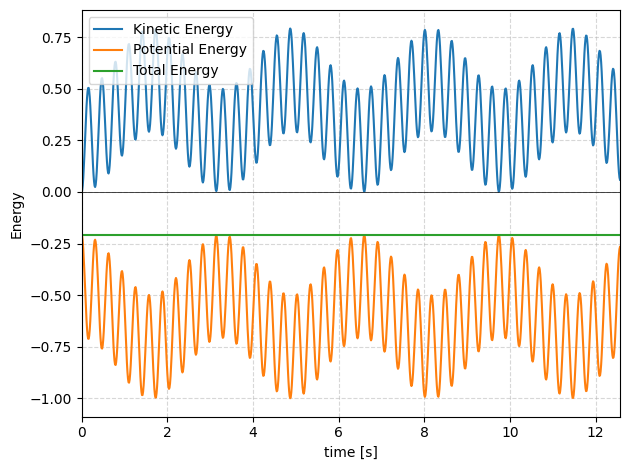

In [2]:
fig, ax = plt.subplots(tight_layout=True)

energy_evolution.ekin.plot(label="Kinetic Energy")
energy_evolution.epot.plot(label="Potential Energy")
energy_evolution.etot.plot(label="Total Energy")

plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color='black', lw=0.5)
plt.xlim(0, endtime)
plt.ylabel("Energy")
plt.legend()